# Analogue Field Test 1 Data Analysis

Krystal Arroyo-Flores  
10/19/2023

#### *Code Imports*

In [1]:
%matplotlib widget

# Our standard imports:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib import cm
import seaborn as sn
from pandas.testing import assert_frame_equal

# Access to many standard distributions:
import scipy.stats as ss
import pandas as pd
import re
import csv
import xarray as xr
import math as mth

### **START**
Already shortened: *df_fielddata*, *df_refdata*, *df_all*, *corrMx*

In [2]:
## Step 1
# selections = ['specfiles_org_ascend2023_field.csv','specfiles_org_ascend2023_lib.csv'] # ordered, labels in 2nd column, field by spot
selections = ['specfiles_org_ascend2023_field2.csv','specfiles_org_ascend2023_lib.csv'] # field w/ AM & PM groups

filenameslist = []
labelnameslist = []
for s in selections:
    names = []
    names = pd.read_csv(s)
    filenames = names.FileName.tolist()
    labelnames = names.LabelName.tolist()
    for count, fn in enumerate(filenames):
        if '\n' in fn:
            fn = fn.split('\n')[1]
            filenames[count] = fn
    filenameslist.append(filenames)
    labelnameslist.append(labelnames)
    
print(filenameslist)
print(len(filenameslist[0]),len(filenameslist[1])) # 68 field, 27 lib
print(labelnameslist)
print(len(labelnameslist[0]),len(labelnameslist[1])) # 68 field, 27 lib


[['friamwr_avg.md', 'friam_basaltspot1_median.md', 'friam_spot2lyr_top_avg.md', 'friam_spot2lyr_middlelight_avg.md', 'friam_spot2lyr_thirddark_avg.md', 'friam_spot4_xenopyx_avg_2-7.md', 'satam_sp2_med.md', 'satam_sp3_med.md', 'satam_sp4_med.md', 'satam_sp5_med.md', 'satam_sp6_med.md', 'satam_sp7_med.md', 'satam_sp8_med.md', 'satam_sp9_med.md', 'satam_sp10_med.md', 'satam_sp11_med.md', 'satam_sp12_med.md', 'fripm_spcenter_med.md', 'fripm_sp2_med.md', 'fripm_sp3_med.md', 'fripm_sp4_med.md', 'fripm_sp5_med.md', 'fripm_sp6_med.md', 'fripm_sp7_med.md', 'fripm_sp8_med.md', 'fripm_sp9_med.md', 'fripm_sp10_median.md', 'fripm_sp11N_med.md', 'fripm_sp12_med.md', 'satam_sp13_med.md', 'satam_sp14_med.md', 'satam_sp15_med.md', 'satam_sp16_med.md', 'satam_sp17_med.md', 'satam_sp18_med.md', 'satam_sp19_med.md', 'satam_sp20_med.md', 'satam_sp21_med.md', 'satam_sp22_med.md', 'satam_sp23_med.md', 'satam_sp24_med.md', 'satpm_1twobigrks_med.md', 'satpm_20_med.md', 'satpm_3bigrock_med.md', 'satpm_3bigrock_

In [4]:
## Step 2
directory = ['averagedfilenames_field.csv','averagedfilenames_lib.csv'] # where the actual data files are

datafiles = []
for d in directory:
    names = []
    names = pd.read_csv(d)
    names = names.Name.tolist()
    datafiles.append(names)
# print(datafiles)

df_fielddata = pd.DataFrame()
df_wavelengths = pd.DataFrame()
df_refdata = pd.DataFrame()

for count, filelist in enumerate(datafiles): # 2 lists, one from field csv, one from lib csv (all file names in data folders)
    if count>0: # finished iterating through field files
        ## create empty dataframe w/ our wavelength range as index, taken from field data df [350:2500]
        w = pd.DataFrame({'Wavelength':df_wavelengths[df_wavelengths.columns[0]].values}, dtype=float)
        w = w.set_index('Wavelength')
        df_refdata = df_refdata.reindex(w.index)
        df_fielddata = df_fielddata.set_index(w.index)
        # print('Wavelength section: \n',df_refdata,'\n',df_fielddata)
    
    for idx, val in np.ndenumerate(filenameslist[0]): # go through field selection order
        for fn in filelist: # fn is the full txt file name, filenameslist has the xxxx.md version
            
            if val in fn:
                i=idx[0]
                label = labelnameslist[0][i]
                path = 'Krystal_ASD_Data/MK_Averaged/' + fn
                specdata = []
                specdata = pd.read_csv(path,delimiter="\t",header=39, index_col=0)
                df_fielddata[label] = specdata[specdata.columns[0]]   # if set index, use col[0] instead of [1]
                df_wavelengths[label] = specdata.index # if set index, use .index to get instead of [specdata.columns[0]], uses shortened file name
                # print('Field section: \n',df_fielddata,'\n',df_wavelengths,'\n\n')
                
    for idx, val in np.ndenumerate(filenameslist[1]): # go through library selection order
        for fn in filelist: # fn is the full tab file name, filenameslist has the xxxx(no .tab) version
            if val in fn:
                i=idx[0]
                label = labelnameslist[1][i]
                path = 'Spectral_Library_Files/' + fn
                refdata = []
                with open(path, 'r') as file:   # get length of data for specific file - consulted chatgpt for syntax
                    length = int(file.readline().strip())
                    ## correct length, only the numbers (as floats), only Wavelength (as index) & Reflectance (named w/ shortened file name)
                    refdata = pd.read_csv(path, skiprows=1, nrows=length, sep="\s+", header=None, dtype=float, names=['Wavelength',label,'StdDev'], index_col=0)
                    dataset_ref = refdata.iloc[0:,0:1]
                    result = w.join(dataset_ref) # map current file data to standard Wavelength range (adds NaNs)
                    df_refdata = pd.concat([df_refdata,result[result.columns[0]]],axis=1)
                    # print('Library section: \n',result,'\n',df_refdata,'\n\n')
            
# print('Field data: ',len(df_fielddata),'\n\n',df_fielddata,'\n\n')
# print('Library data: ',len(df_refdata),'\n\n',df_refdata)
df_fielddata.info() # *** only 65 cols, 3 files got dropped, fix*******
df_refdata.info()
# df_refdata.dtypes  # checks data types
# df_refdata.count() # gives non-null totals


<class 'pandas.core.frame.DataFrame'>
Float64Index: 2151 entries, 350.0 to 2500.0
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 2151 non-null   float64
 1   PS 01 Basalt             2151 non-null   float64
 2   PS 02 Top Soil           2151 non-null   float64
 3   PS 02 Mid, Light         2151 non-null   float64
 4   PS 02 Bottom, Dark       2151 non-null   float64
 5   PS 04 PyroxRock          2151 non-null   float64
 6   Spiral 02_AM             2151 non-null   float64
 7   Spiral 03_AM             2151 non-null   float64
 8   Spiral 04_AM             2151 non-null   float64
 9   Spiral 05_AM             2151 non-null   float64
 10  Spiral 06_AM             2151 non-null   float64
 11  Spiral 07_AM             2151 non-null   float64
 12  Spiral 08_AM             2151 non-null   float64
 13  Spiral 09_AM             2151 non-null   float64
 14  Spiral 10_AM    

In [5]:
## Step 3

## create correlation matrix - FIELD vs LIBRARY - All(both)
df_all = pd.concat([df_fielddata,df_refdata],axis=1)
corrMx = df_all.corr() #.corr(method='pearson')#,'kendall','spearman')
print('All data: ',len(df_all),'\n\n',df_all,'\n\n')
print('Correlation Matrix: ',len(corrMx),'\n\n',corrMx)
df_all.info()
corrMx.info()

All data:  2151 

             PS Setup  PS 01 Basalt  PS 02 Top Soil  PS 02 Mid, Light  \
Wavelength                                                             
350.0       0.016146      0.018525        0.016985          0.021962   
351.0       0.016002      0.018455        0.017070          0.022015   
352.0       0.015951      0.018537        0.016873          0.022002   
353.0       0.016247      0.018499        0.016856          0.022066   
354.0       0.016270      0.018533        0.016990          0.022107   
...              ...           ...             ...               ...   
2496.0      0.000029      0.106448        0.048960          0.105140   
2497.0      0.005046      0.112110        0.048714          0.104610   
2498.0      0.035094      0.109559        0.048528          0.105506   
2499.0      0.041443      0.105511        0.050883          0.104564   
2500.0      0.052210      0.072024        0.059441          0.099409   

            PS 02 Bottom, Dark  PS 04 PyroxR

# Remove Noise from Analog Data and Plot Before and After
Shortened: *df_chop*

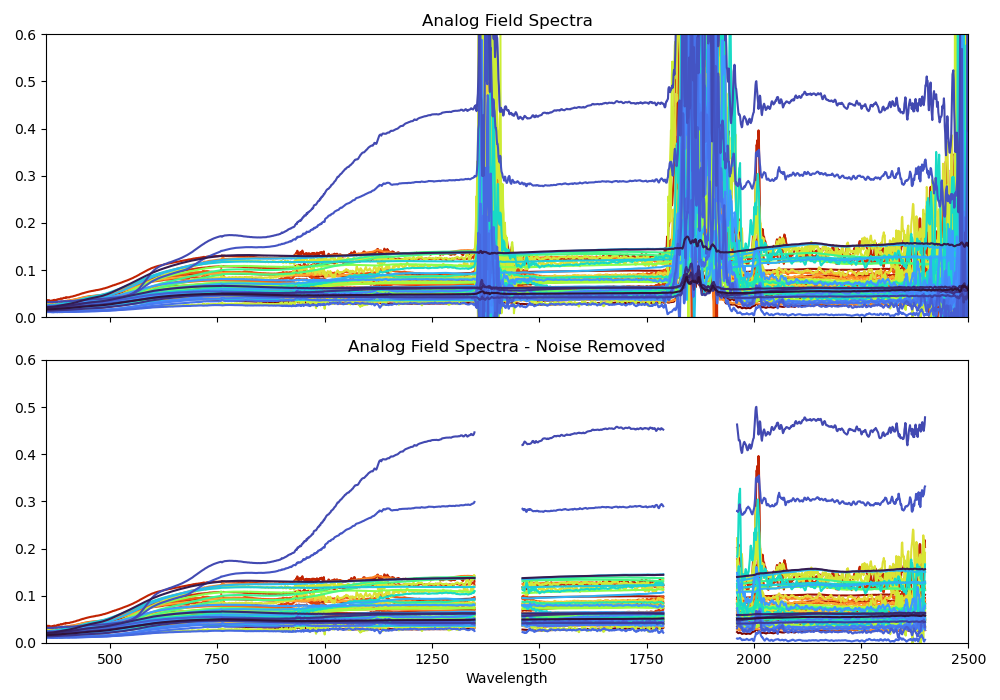

In [6]:
## Step 4

## Field Data Plot (df_fielddata)
plt.close('all')
f_field, (ax_field, ax_chop) = plt.subplots(2, sharex=True, sharey=True) # creates matplotlib figure - 2 vertically stacked subplots, share x-axis & y-axis scale

df_fielddata.plot(figsize=(10,7),ax=ax_field,legend=False,colormap='turbo_r') # (width, height) in inches
ax_field.set_title('Analog Field Spectra')


## create new dataframe with noisy bands changed to NaNs
w_noise = [[1350,1460],[1790,1960],[2400,2500]]

df_chop = df_fielddata.copy()
for band, vals in enumerate(w_noise):
    df_chop.loc[vals[0]:vals[1]]=np.nan


## plot the dataframe after - Field Data Plot (df_chop)
df_chop.plot(ax=ax_chop,legend=False,colormap='turbo_r') # (width, height) in inches
ax_chop.set_title('Analog Field Spectra - Noise Removed')

plt.ylim(0,0.6)
plt.xlim(350,2500)
f_field.tight_layout(pad=1) # handles margins
plt.show()

# Save plot to file
f_field.savefig('analogSpectra_Noise.pdf')

In [7]:
## Step 5
df_chop.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2151 entries, 350.0 to 2500.0
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 1768 non-null   float64
 1   PS 01 Basalt             1768 non-null   float64
 2   PS 02 Top Soil           1768 non-null   float64
 3   PS 02 Mid, Light         1768 non-null   float64
 4   PS 02 Bottom, Dark       1768 non-null   float64
 5   PS 04 PyroxRock          1768 non-null   float64
 6   Spiral 02_AM             1768 non-null   float64
 7   Spiral 03_AM             1768 non-null   float64
 8   Spiral 04_AM             1768 non-null   float64
 9   Spiral 05_AM             1768 non-null   float64
 10  Spiral 06_AM             1768 non-null   float64
 11  Spiral 07_AM             1768 non-null   float64
 12  Spiral 08_AM             1768 non-null   float64
 13  Spiral 09_AM             1768 non-null   float64
 14  Spiral 10_AM    

# Analog Correlation Matrix, No Noise

### Create Analog Correlation Matrix from DataFrame w/ NaN-Replaced Noise Bands, Shorten File Names, Check Equality
Shortened: *corrMx_analog*

In [9]:
## Step 6
corrMx_analog = df_chop.corr() #.corr(method='pearson')#,'kendall','spearman')
corrMx_analog.info() # shortened

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, PS Setup to Slope 18 TopMxdGravel
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 65 non-null     float64
 1   PS 01 Basalt             65 non-null     float64
 2   PS 02 Top Soil           65 non-null     float64
 3   PS 02 Mid, Light         65 non-null     float64
 4   PS 02 Bottom, Dark       65 non-null     float64
 5   PS 04 PyroxRock          65 non-null     float64
 6   Spiral 02_AM             65 non-null     float64
 7   Spiral 03_AM             65 non-null     float64
 8   Spiral 04_AM             65 non-null     float64
 9   Spiral 05_AM             65 non-null     float64
 10  Spiral 06_AM             65 non-null     float64
 11  Spiral 07_AM             65 non-null     float64
 12  Spiral 08_AM             65 non-null     float64
 13  Spiral 09_AM             65 non-null     float64
 14  Spiral 

### Create Analog DataFrame w/ Dropped Noise Bands, Create Correlation Matrix
Shortened: *df_drop*, *corrMx_analog2*

In [10]:
## Step 7
## drop bands
w_noise = [[1350,1460],[1790,1960],[2400,2500]]
df_drop = df_fielddata.copy()

for band, vals in enumerate(w_noise):
    df_drop = df_drop.drop(df_drop.loc[vals[0]:vals[1]].index)
# with pd.option_context('display.max_rows', None):
#     print(df_drop,'\n')
# df_drop.info()

## make new corr matrix - No Noise (df_drop - NO NaNs)
corrMx_analog2 = df_drop.corr() #.corr(method='pearson')#,'kendall','spearman')
df_drop.info()
corrMx_analog2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1768 entries, 350.0 to 2399.0
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PS Setup                 1768 non-null   float64
 1   PS 01 Basalt             1768 non-null   float64
 2   PS 02 Top Soil           1768 non-null   float64
 3   PS 02 Mid, Light         1768 non-null   float64
 4   PS 02 Bottom, Dark       1768 non-null   float64
 5   PS 04 PyroxRock          1768 non-null   float64
 6   Spiral 02_AM             1768 non-null   float64
 7   Spiral 03_AM             1768 non-null   float64
 8   Spiral 04_AM             1768 non-null   float64
 9   Spiral 05_AM             1768 non-null   float64
 10  Spiral 06_AM             1768 non-null   float64
 11  Spiral 07_AM             1768 non-null   float64
 12  Spiral 08_AM             1768 non-null   float64
 13  Spiral 09_AM             1768 non-null   float64
 14  Spiral 10_AM    

## No-Noise Analog Heatmap (created using drop DataFrame)

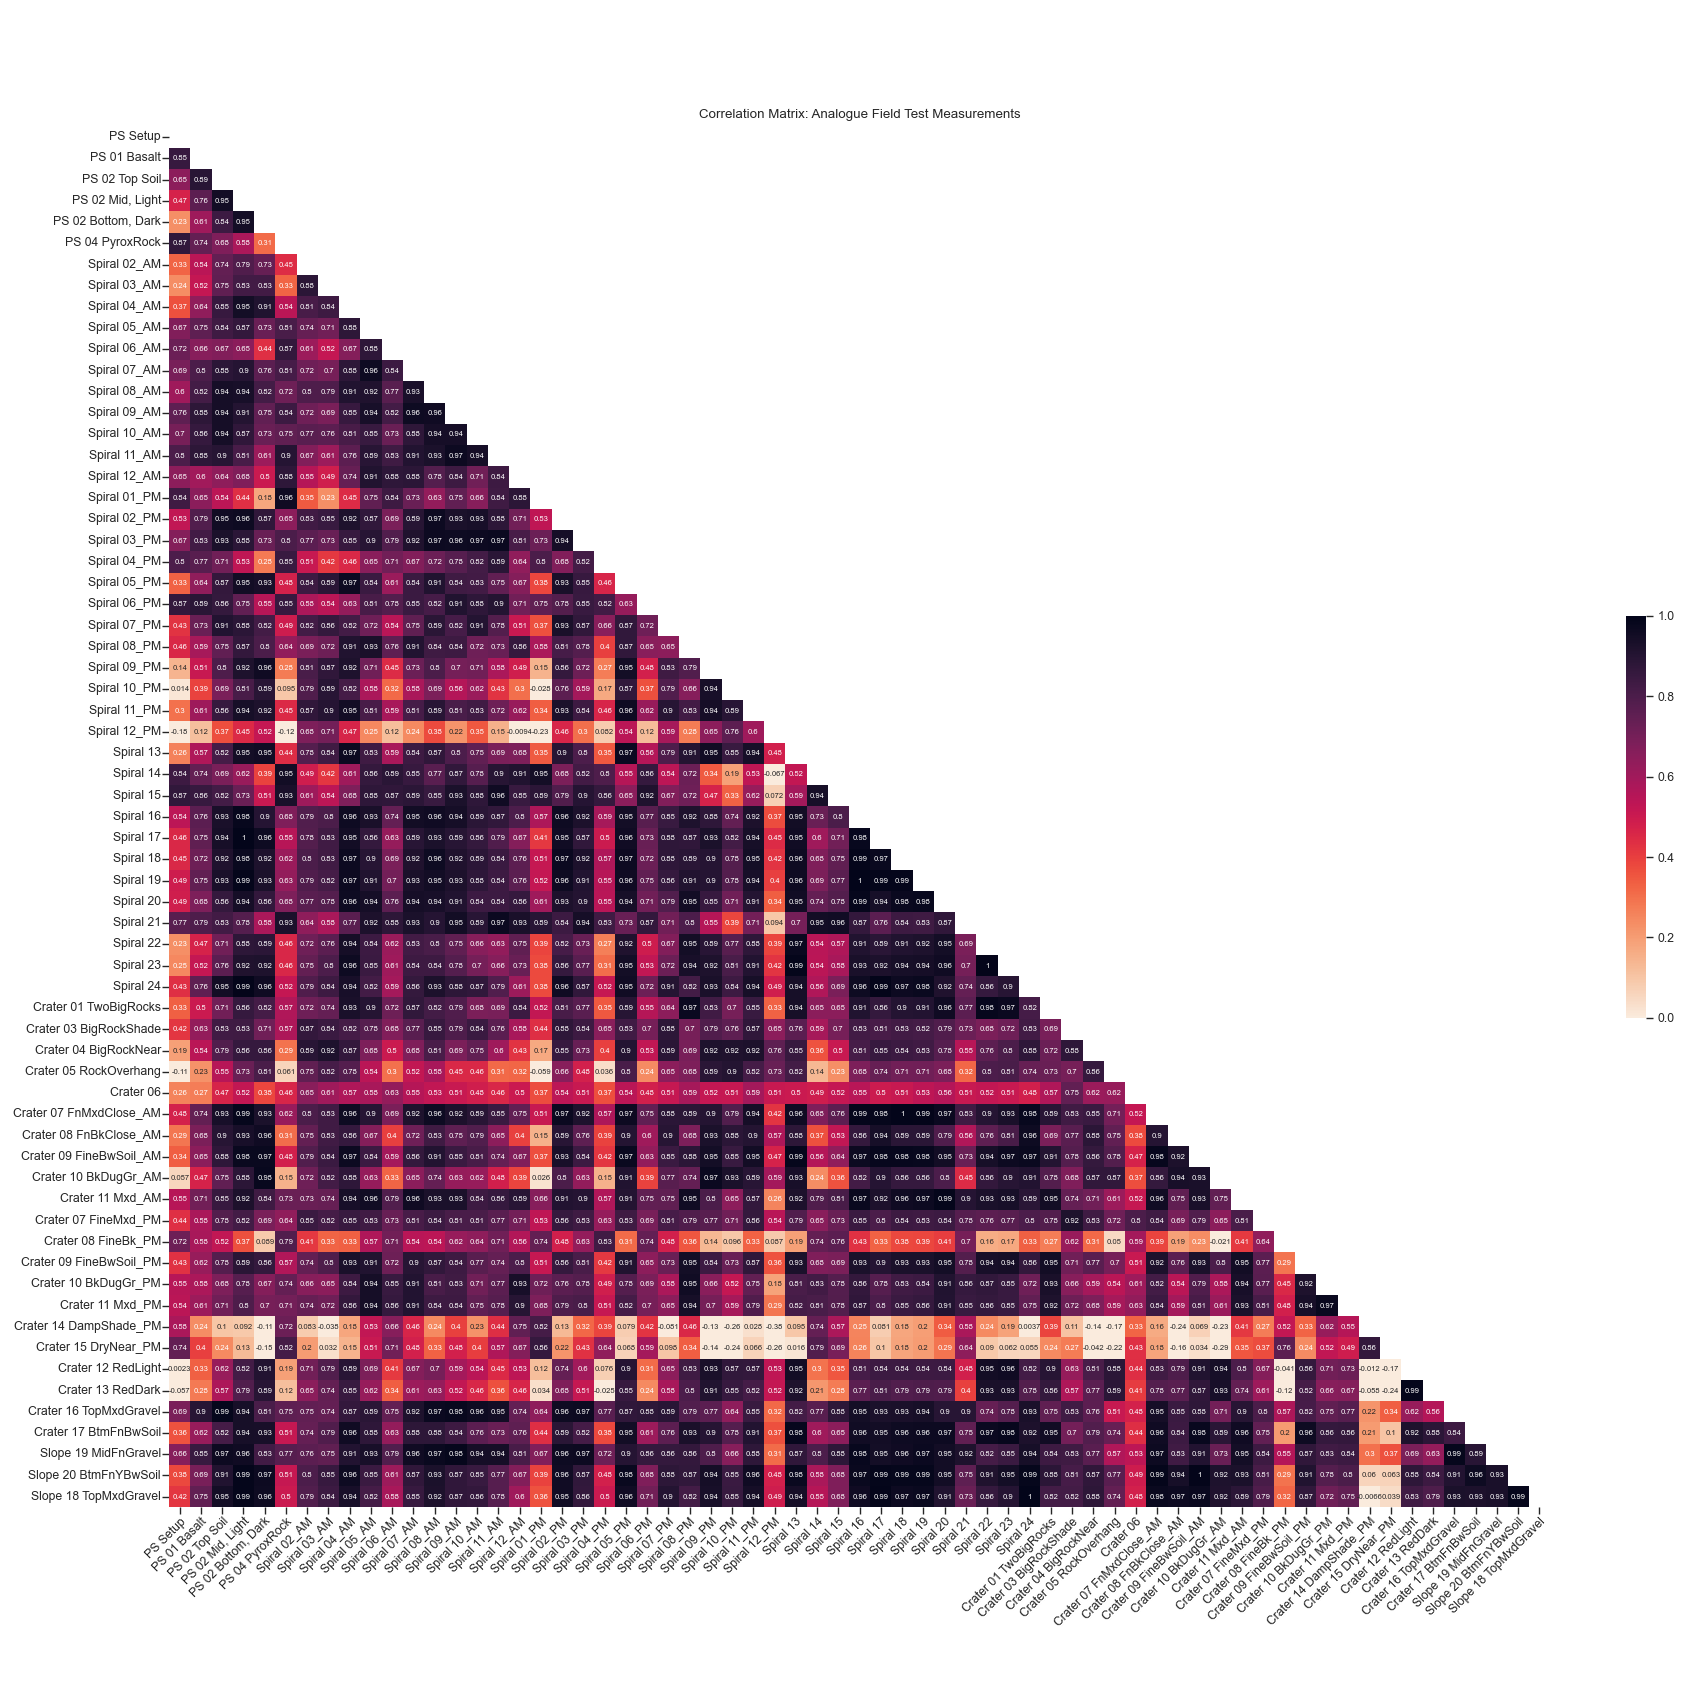

                        PS Setup  PS 01 Basalt  PS 02 Top Soil  \
PS Setup                1.000000      0.854588        0.647521   
PS 01 Basalt            0.854588      1.000000        0.892147   
PS 02 Top Soil          0.647521      0.892147        1.000000   
PS 02 Mid, Light        0.470277      0.758272        0.951614   
PS 02 Bottom, Dark      0.233793      0.606370        0.840696   
...                          ...           ...             ...   
Crater 16 TopMxdGravel  0.691146      0.895261        0.986341   
Crater 17 BtmFnBwSoil   0.361501      0.624647        0.819407   
Slope 19 MidFnGravel    0.662150      0.848952        0.966302   
Slope 20 BtmFnYBwSoil   0.380329      0.693481        0.913883   
Slope 18 TopMxdGravel   0.420880      0.747538        0.947762   

                        PS 02 Mid, Light  PS 02 Bottom, Dark  PS 04 PyroxRock  \
PS Setup                        0.470277            0.233793         0.869857   
PS 01 Basalt                    0.758272     

In [13]:
## Step 8

## Correlation Matrix Plot - field only, all spots, lower half, shorter names, NO NOISE **with pre-shortened names in (corrMx_analog2)**
plt.close('all')

sn.set_theme(style='white')
sn.set_context('paper', font_scale=1.0) # paper,notebook,talk,poster
mask_analog = np.triu(np.ones_like(corrMx_analog2, dtype=bool),0) # Generate a mask for the upper triangle (where those cells = True)
f_analog, ax_analog = plt.subplots(figsize=(17,17)) # creates matplotlib figure
ax_analog = sn.heatmap(corrMx_analog2, vmin=0, vmax=1, square=True, 
                       annot=True, annot_kws={'size':5.5}, cmap='rocket_r', mask=mask_analog, 
                       cbar_kws={'fraction':0.04,'shrink':0.25,'pad':0.05}) 
# annotated w/ coeffs, masks upper triangle, sets color floor at 0, keeps cells square, shrinks colorbar

title = 'Correlation Matrix: Analogue Field Test Measurements'
ax_analog.set_title(title)
ax_analog.tick_params(axis='both',pad=1)#,labelsize=7)
ax_analog.tick_params(left=True,top=False, bottom=True,labeltop=False, labelbottom=True)
plt.setp(ax_analog.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # Rotate the tick labels and set their alignment.
f_analog.tight_layout(pad=1) # handles margins
plt.show()

## Save plot to file
f_analog.savefig('analogMx_NoNoise_Ltri.pdf')

print(corrMx_analog2)

In [14]:
## Save plot to file - PNG
f_analog.savefig('analogMx_NoNoise_Ltri.png')